In [5]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [50, 10]

In [3]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")
    return image

def capture_image_from_camera():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise ValueError("Unable to access the camera.")

    print("Press 's' to capture the image.")
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        cv2.imshow("Sudoku Capture", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):  # Нажмите 's', чтобы сохранить изображение
            captured_image = frame.copy()
            break
        elif key == ord('q'):  # Нажмите 'q', чтобы выйти
            cap.release()
            cv2.destroyAllWindows()
            raise ValueError("Image capture aborted by user.")

    cap.release()
    cv2.destroyAllWindows()
    return captured_image

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Пороговая обработка
    # _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)
    return threshold

def find_largest_contour(threshold):
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    peri=cv2.arcLength(largest_contour, True)
    polygone=cv2.approxPolyDP(largest_contour, 0.02*peri, True)

    return polygone

def get_rectangle_corners(polygone):
    points = sorted(np.vstack(polygone).squeeze(), key=lambda x: (x[1], x[0]))
    top_left, top_right = sorted(points[:2], key=lambda x: x[0])
    bottom_left, bottom_right = sorted(points[2:], key=lambda x: x[0])
    return top_left, top_right, bottom_right, bottom_left


marge = 4
case = 28 + 2 * marge
width = height = 9 * case

# Исправление перспективы
def perspective_transform(image, points):
    src = np.array(points, dtype=np.float32)
    destination =np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    matrix = cv2.getPerspectiveTransform(np.array(src, dtype="float32"), destination)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    return warped

# 3. Разделение на клетки
def split_into_cells(warped_image):
    height, width = warped_image.shape[:2]
    cell_height, cell_width = height // 9, width // 9
    cells = []

    for row in range(9):
        for col in range(9):
            y1, y2 = row * cell_height, (row + 1) * cell_height
            x1, x2 = col * cell_width, (col + 1) * cell_width
            cell = warped_image[y1:y2, x1:x2]
            cells.append(cell)

    return cells


def draw_grid(image):
    height, width = image.shape[:2]
    cell_height, cell_width = height // 9, width // 9

    for row in range(9):
        for col in range(9):
            y1, y2 = row * cell_height, (row + 1) * cell_height
            x1, x2 = col * cell_width, (col + 1) * cell_width
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    return image


def draw_digits(image, digits):
    height, width = image.shape[:2]
    cell_height, cell_width = height // 9, width // 9

    for row in range(9):
        for col in range(9):
            y1 = row * cell_height
            x1 = col * cell_width

            digit = digits[row * 9 + col]
            if digit != 0:
                cv2.putText(image, str(digit), (x1 + cell_width // 4, y1 + 3 * cell_height // 4),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    return image



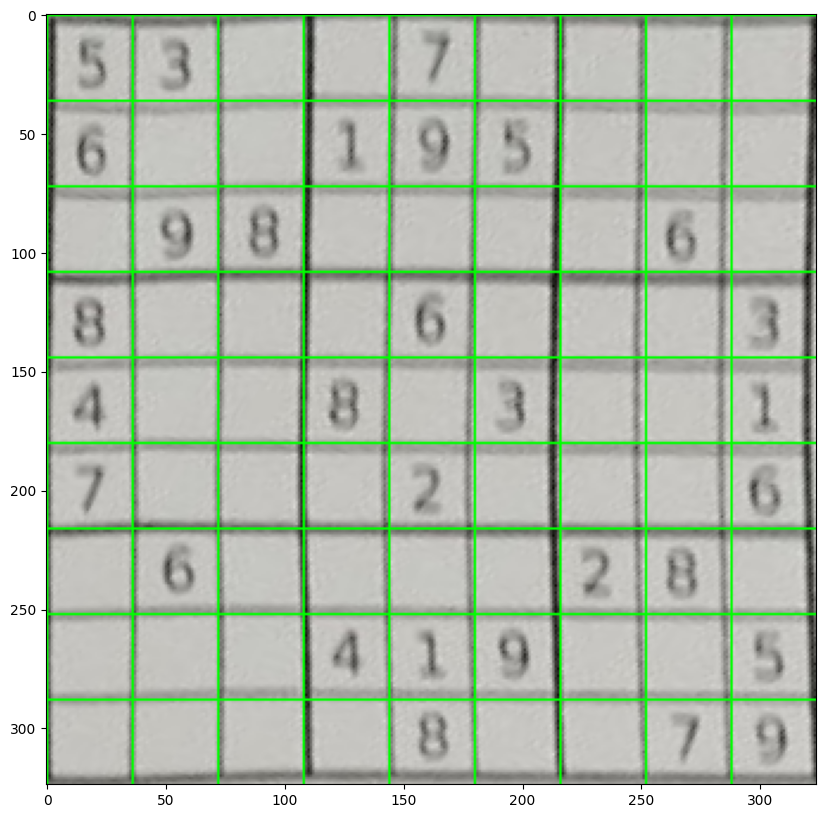

In [7]:
image_path = 'image_1.jpg'

image = load_image(image_path)
# image = capture_image_from_camera()
threshold = preprocess_image(image)
polygon = find_largest_contour(threshold)
corners = get_rectangle_corners(polygon)
transformed_image = perspective_transform(image, corners)
# cells = split_into_cells(transformed_image)

result_image = draw_grid(transformed_image.copy())
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))


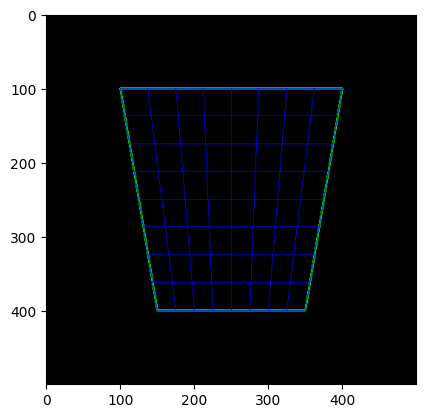

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Координаты четырехугольника (упорядочены: [верхний левый, верхний правый, нижний правый, нижний левый])
polygon = np.array([[100, 100], [400, 100], [350, 400], [150, 400]])

# Размер сетки (9x9)
grid_size = 9

# Создаем пустое изображение для визуализации
image = np.zeros((500, 500, 3), dtype=np.uint8)

# Рисуем исходный четырехугольник
cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)

# Функция для вычисления интерполяции между двумя точками
def interpolate_points(p1, p2, num_points):
    return [((1 - t) * p1[0] + t * p2[0], (1 - t) * p1[1] + t * p2[1]) for t in np.linspace(0, 1, num_points)]

# Разбиваем стороны четырехугольника на равные части
top_side = interpolate_points(polygon[0], polygon[1], grid_size)
bottom_side = interpolate_points(polygon[3], polygon[2], grid_size)
left_side = interpolate_points(polygon[0], polygon[3], grid_size)
right_side = interpolate_points(polygon[1], polygon[2], grid_size)

# Рисуем горизонтальные линии сетки
for i in range(grid_size):
    start = top_side[i]
    end = bottom_side[i]
    cv2.line(image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 0, 0), 1)

# Рисуем вертикальные линии сетки
for i in range(grid_size):
    start = left_side[i]
    end = right_side[i]
    cv2.line(image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 0, 0), 1)

# Показываем изображение с сеткой
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


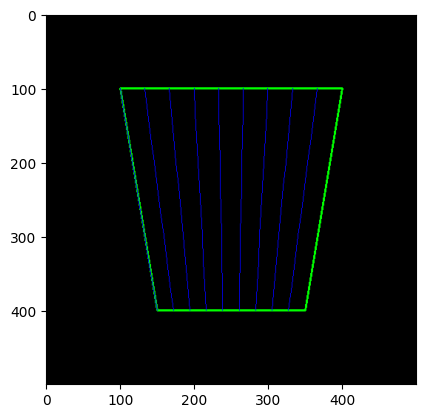

In [11]:
import cv2
import numpy as np

# Координаты четырехугольника (упорядочены: [верхний левый, верхний правый, нижний правый, нижний левый])
polygon = np.array([[100, 100], [400, 100], [350, 400], [150, 400]])

# Размер сетки (9x9)
grid_size = 10

# Создаем пустое изображение для визуализации
image = np.zeros((500, 500, 3), dtype=np.uint8)

# Рисуем исходный четырехугольник
cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)

# Функция для вычисления интерполяции между двумя точками
def interpolate_points(p1, p2, num_points):
    return [((1 - t) * p1[0] + t * p2[0], (1 - t) * p1[1] + t * p2[1]) for t in np.linspace(0, 1, num_points)]

# Разбиваем стороны четырехугольника на равные части
top_side = interpolate_points(polygon[0], polygon[1], grid_size)
bottom_side = interpolate_points(polygon[3], polygon[2], grid_size)

# Вычисляем центры ячеек в нормализованных координатах (0-1)
cell_centers = []
for i in range(grid_size - 1):  # Проход по строкам
    for j in range(grid_size - 1):  # Проход по столбцам
        # Линии по текущим вертикальным интервалам
        top_interp = interpolate_points(top_side[i], bottom_side[i], grid_size)
        bottom_interp = interpolate_points(top_side[i + 1], bottom_side[i + 1], grid_size)

        # Центр текущей ячейки
        cell_center = (
            (top_interp[j][0] + bottom_interp[j + 1][0]) / 2,
            (top_interp[j][1] + bottom_interp[j + 1][1]) / 2
        )
        cell_centers.append(cell_center)

# Гомография: нормализованный квадрат -> четырехугольник
src_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]], dtype=np.float32)
dst_points = polygon.astype(np.float32)
h_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

# Преобразование центров через гомографию
transformed_centers = []
for center in cell_centers:
    point = np.array([center[0], center[1], 1], dtype=np.float32).reshape(3, 1)
    transformed_point = np.dot(h_matrix, point)
    transformed_point /= transformed_point[2, 0]  # Нормализация
    transformed_centers.append((int(transformed_point[0, 0]), int(transformed_point[1, 0])))

# Рисуем сетку
for i in range(grid_size):
    top_interp = interpolate_points(top_side[i], bottom_side[i], grid_size)
    for j in range(grid_size):
        if i < grid_size - 1 and j < grid_size - 1:
            cv2.line(image, (int(top_interp[j][0]), int(top_interp[j][1])),
                     (int(top_interp[j + 1][0]), int(top_interp[j + 1][1])), (255, 0, 0), 1)

# Рисуем числа на трансформированных координатах
for idx, center in enumerate(transformed_centers):
    cv2.putText(image, str(idx + 1), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

(<Axes: >, <matplotlib.image.AxesImage at 0x7d8c49155750>)

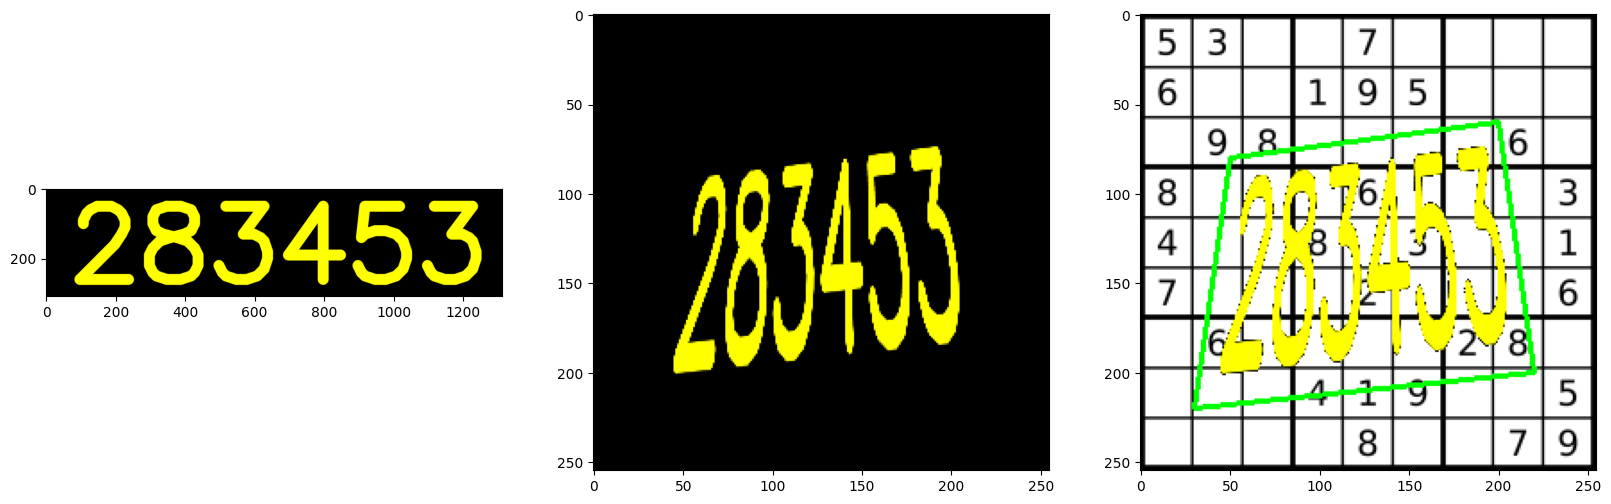

In [44]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 1. Загрузка фонового изображения
background = cv2.imread('s255.png')  # Замените 'background.jpg' на путь к вашему изображению
height, width, _ = background.shape

# 2. Создание пустого изображения для текста
# text_image = np.zeros((100, 100, 3), dtype=np.uint8)

# Текст и параметры шрифта
text = "283453"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 10
thickness = 30
margin_text = 30 # percentage

# Позиция для начала рисования текста
(text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
margin = int(text_height * margin_text/100)
text_width += margin + thickness//2
text_height += margin + thickness//2
text_image = np.zeros((text_height , text_width, 3), dtype=np.uint8)
cv2.putText(text_image, text, (margin, text_height - margin//2 -  thickness//2), font, font_scale, (0, 255, 255), thickness, cv2.LINE_AA)

# Координаты четырёхугольного полигона
polygon_pts = np.array([[50, 80], [200, 60], [220, 200], [30, 220]], dtype=np.float32)

# 3. Нарисуем текст на пустом изображении

# Задаем целевые координаты для трансформации (полигона)
destination_pts = np.array([[polygon_pts[0][0], polygon_pts[0][1]],
                            [polygon_pts[1][0], polygon_pts[1][1]],
                            [polygon_pts[2][0], polygon_pts[2][1]],
                            [polygon_pts[3][0], polygon_pts[3][1]]], dtype=np.float32)

# Вычисляем матрицу перспективного преобразования
# Определяем исходные точки как углы bounding box текста
src_pts = np.array([[0, 0], [text_width, 0],
                    [text_width, text_height], [0, text_height]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src_pts, destination_pts)

# Применяем перспективное преобразование
warped_text_image = cv2.warpPerspective(text_image, M, (width, height))

# 4. Наложение искаженного текста на фоновое изображение

# Мы будем использовать маску текста для наложения на фон
gray_warped_text = cv2.cvtColor(warped_text_image, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_warped_text, 1, 255, cv2.THRESH_BINARY)

# Инвертируем маску для того, чтобы наложить текст на фон
mask_inv = cv2.bitwise_not(mask)

# Извлекаем область фона, куда будет наложен текст
background_region = cv2.bitwise_and(background, background, mask=mask_inv)

# Извлекаем сам текст из искаженного изображения
text_region = cv2.bitwise_and(warped_text_image, warped_text_image, mask=mask)

# Наложение текста на фон
result = cv2.add(background_region, text_region)

# 5. Нарисовать рамку для полигона на фоне
polygon_pts_int = polygon_pts.astype(np.int32)  # Преобразуем координаты в целые числа
cv2.polylines(result, [polygon_pts_int], isClosed=True, color=(0, 255, 0), thickness=2)  # Рисуем рамку полигона (зеленая)

plt.subplot(131), plt.imshow(cv2.cvtColor(text_image, cv2.COLOR_BGR2RGB))
plt.subplot(132), plt.imshow(cv2.cvtColor(warped_text_image, cv2.COLOR_BGR2RGB))
plt.subplot(133), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

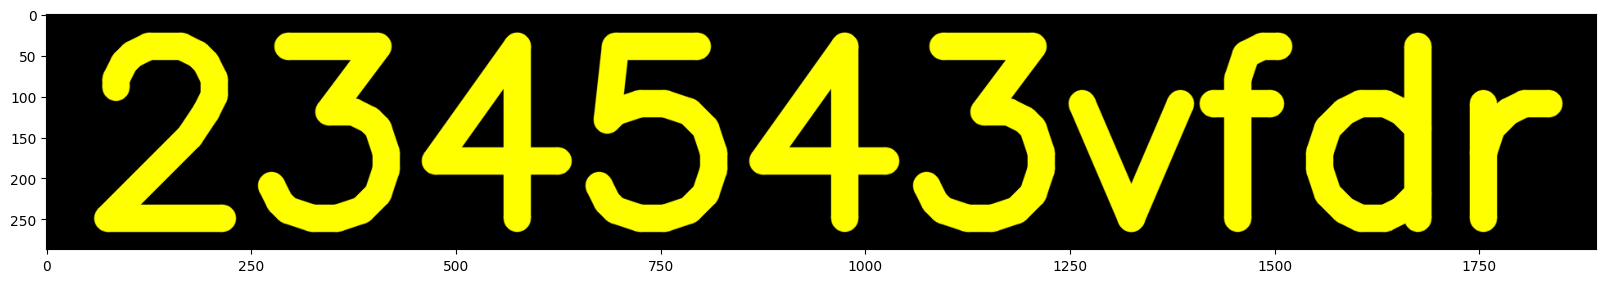

In [40]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
# Текст и параметры шрифта
text = "234543vfdr"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 10
thickness = 32
margin_text = 20 # percentage

# Позиция для начала рисования текста
(text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
margin = int(text_height * margin_text/100)
text_width += margin + thickness//2
text_height += margin + thickness//2
text_image = np.zeros((text_height , text_width, 3), dtype=np.uint8)
cv2.putText(text_image, text, (margin, text_height - margin//2 -  thickness//2), font, font_scale, (0, 255, 255), thickness, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(text_image, cv2.COLOR_BGR2RGB))